In [62]:
# import packages
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import dask
import numpy as np
import cartopy.feature as cfeature
import scipy.stats as st

from matplotlib import pyplot as plt
from datetime import datetime
from netCDF4 import Dataset
from scipy import stats

In [63]:
# Open .nc data files
data = xr.open_dataset('filename.nc', chunks = 'auto')
data_2040 = xr.open_dataset('filename_2040.nc', chunks = 'auto')

# T-test

In [64]:
# Enter the desired start/end point of latitude or longitude, and interval
def coordinate(start,end,interval):
    if start < 0:
        start = 360 - abs(start)
    if end < 0:
        end = 360 - abs(end)
    interval = abs((start - end)/interval - 1)
    return np.linspace(int(start), int(end), int(interval)) 

In [65]:
# Example
lon_start = -93
lon_end = -75
lon_int = 0.25

lat_start = 40
lat_end = 50
lat_int = 0.25

In [66]:
# Slice the data file to the desired region
data_s = data['TREFHT'].sel(lon = coordinate(lon_start, lon_end, lon_int), method="nearest").sel(lat = coordinate(lat_start, lat_end, lat_int), method="nearest")

# Compute seasonal average
data_s_season = data_s.groupby("time.season").mean()

# Yearly average for each season
month_length = data_s.time.dt.days_in_month
data_season = ((data_s * month_length).resample(time='QS-DEC').sum() / month_length.resample(time='QS-DEC').sum())

In [67]:
data_2040['time'] = data['time']

In [68]:
# Slice the data file to the desired region
data_2040_s = data_2040['TREFHT'].sel(lon = coordinate(lon_start, lon_end, lon_int), method="nearest").sel(lat = coordinate(lat_start, lat_end, lat_int), method="nearest")

# Compute seasonal average
data_2040_s_season = data_2040_s.groupby("time.season").mean()

# yearly average for each season
month_length = data_2040_s.time.dt.days_in_month
data_2040_season = ((data_2040_s * month_length).resample(time='QS-DEC').sum() / month_length.resample(time='QS-DEC').sum())

In [69]:
# Perform T-test for each of the seasons
p_DJF = np.zeros((len(data_s['lat']),len(data_s['lon'])))
p_MAM = np.zeros((len(data_s['lat']),len(data_s['lon'])))
p_JJA = np.zeros((len(data_s['lat']),len(data_s['lon'])))
p_SON = np.zeros((len(data_s['lat']),len(data_s['lon'])))

for i in range(len(data_s['lat'])):
    for j in range(len(data_s['lon'])):
        p_DJF[i,j] = st.ttest_ind(data_season.load()[0::4,i,j],data_2040_season.load()[0::4,i,j])[1]
        p_MAM[i,j] = st.ttest_ind(data_season.load()[1::4,i,j],data_2040_season.load()[1::4,i,j])[1]
        p_JJA[i,j] = st.ttest_ind(data_season.load()[2::4,i,j],data_2040_season.load()[2::4,i,j])[1]
        p_SON[i,j] = st.ttest_ind(data_season.load()[3::4,i,j],data_2040_season.load()[3::4,i,j])[1]

In [70]:
# Temperature difference (2040s - 2000s)
diff_DJF = data_2040_season.load()[0::4,:,:].mean(axis=0) - data_season.load()[0::4,:,:].mean(axis=0)
diff_MAM = data_2040_season.load()[1::4,:,:].mean(axis=0) - data_season.load()[1::4,:,:].mean(axis=0)
diff_JJA = data_2040_season.load()[2::4,:,:].mean(axis=0) - data_season.load()[2::4,:,:].mean(axis=0)
diff_SON = data_2040_season.load()[3::4,:,:].mean(axis=0) - data_season.load()[3::4,:,:].mean(axis=0)

# Mask the region where p-value larger than 0.05, indicating not statistically significant
p_DJF = np.ma.masked_where(p_DJF>0.05,p_DJF)
p_MAM = np.ma.masked_where(p_MAM>0.05,p_MAM)
p_JJA = np.ma.masked_where(p_JJA>0.05,p_JJA)
p_SON = np.ma.masked_where(p_SON>0.05,p_SON)

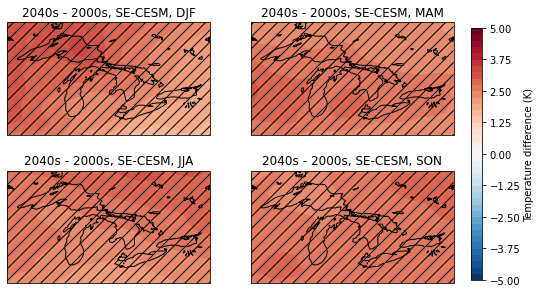

In [71]:
# Produce the plots
row = 2
col = 2
seasons = ['DJF', 'MAM', 'JJA', 'SON']
diff_seasons = [diff_DJF, diff_MAM, diff_JJA, diff_SON]
p_seasons = [p_DJF, p_MAM, p_JJA, p_SON]

fig, axs = plt.subplots(nrows=row,ncols=col,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8,5))
plt.rcParams['font.size'] = 10
axs=axs.flatten()
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m')

for i in range(row * col):
    cs = axs[i].contourf(data_s['lon'], data_s['lat'], diff_seasons[i], np.linspace(-5,5,41),cmap = 'RdBu_r')
    axs[i].contourf(data_s['lon'], data_s['lat'], p_seasons[i], colors = 'none', hatches=['//'])
    axs[i].coastlines()
    axs[i].add_feature(lakes_50m, facecolor='None',edgecolor='black')
    axs[i].set_title('2040s - 2000s, SE-CESM, ' + seasons[i])
    
# Add a colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Temperature difference (K)')

# Save the figure
# plt.savefig('figure.png')